#### Softfloor
Using sigmoid with a scaling factor to reach 1.0 more quickly to control slope at flat regions. Also affects verticalness.

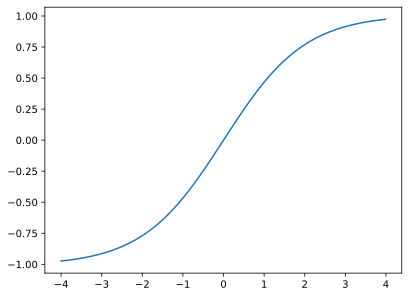

In [ ]:
import sympy
import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_formats = "svg"

factor = 1 + 1e-2

xs = np.arange(-4, 4, 0.01)
ys = factor*(2*(1 / (1 + np.exp(-xs))) - 1)

plt.plot(xs, ys);

5.303304908059047 5.303304908059058


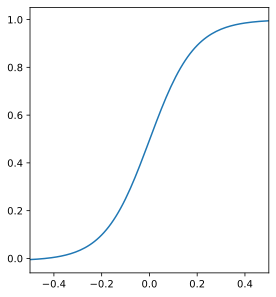

In [ ]:
# fit into unit box

equation = sympy.Eq(1, factor*(2 / (1 + sympy.exp(-sympy.symbols("x"))) - 1))
adjustment = sympy.solve(equation)[0]
adjustment = float(adjustment)
print(adjustment, -np.log(2*factor/(1+factor) - 1))

xs = np.arange(-1, 1, 0.01)
ys = factor*((1 / (1 + np.exp(-2*xs*adjustment))) - 1)

fig, ax = plt.subplots()
ax.set_aspect("equal")
ax.set_xlim(-0.5, 0.5)
ax.plot(xs, ys + 1);
# ax.plot(xs, -ys);

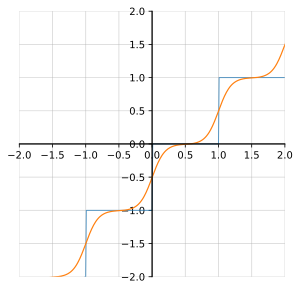

In [ ]:
def f(xs):
    floor = np.floor(xs + 0.5)
    xs = xs - floor
    ys = floor + factor*((1 / (1 + np.exp(-(2*xs)*adjustment))) - 1)

    return ys

xs = np.arange(-5, 5, 0.01)

fig, ax = plt.subplots()
ax.set_aspect("equal")
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
ax.grid(True, alpha=0.5)

for spine in ax.spines.values():
    spine.set_position("zero")

xs_clipped = xs[(-1.02 < xs) & (xs < 1.99)]
ax.plot(xs_clipped, np.floor(xs_clipped), alpha=0.7, linewidth=1);
ax.plot(xs, f(xs), linewidth=1.2);

In [ ]:
import sympy
import torch

def softfloor_make(factor):
    factor = 1 + factor
    equation = sympy.Eq(1, factor*(2 / (1 + sympy.exp(-sympy.symbols("x"))) - 1))
    adjustment = float(sympy.solve(equation)[0])

    def f(xs):
        floor = torch.floor(xs + 0.5)
        xs = xs - floor
        ys = floor + factor*((1 / (1 + torch.exp(-(2*xs)*adjustment))) - 1)

        return ys + 0.5*factor - 0.5

    # sf = factor*((1 / (1 + sympy.exp(-(2*sympy.symbols("x"))*adjustment))) - 1)
    # df = sympy.lambdify("x", sympy.diff(sf))

    return f

def wavy_identity_make(factor):
    assert factor > 1e-2 - 1e-5, f"Value of {factor} violates squiggle-identity aesthetics."

    sf = softfloor_make(factor)

    def f(xs):
        return sf(xs) + 0.5

    return f

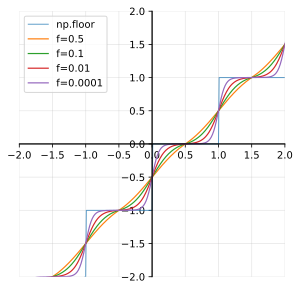

In [ ]:
fig, ax = plt.subplots()
ax.set_aspect("equal")
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
ax.grid(True, alpha=0.3)
for spine in ax.spines.values():
    spine.set_position("zero")

factors = [0.5, 1e-1, 1e-2, 1e-4]

xs = np.arange(-5, 5, 0.01)
xs_clipped = xs[(-1.02 < xs) & (xs < 1.99)]
ax.plot(xs_clipped, np.floor(xs_clipped), alpha=0.7, linewidth=1)

for factor in factors:
    f = softfloor_make(factor)
    ax.plot(xs, f(torch.tensor(xs)), linewidth=1.2)

ax.legend(["np.floor"] + [f"f={factor}" for factor in factors]);

Check gradients

(tensor([-3.0209, -2.6904, -2.5235, -2.0930, -1.9191, -1.8531, -1.5062, -1.1472,
         -0.9486, -0.7607, -0.3028, -0.2541,  0.0061,  0.0315,  0.4365,  1.0107,
          0.7954,  1.1650,  1.5392,  1.9971,  2.0975,  2.3042,  2.4484,  2.6944],
        grad_fn=<AddBackward0>),
 tensor([-2.6456, -0.3732, -0.0676, -2.1198, -2.2399, -1.5390, -0.0563, -1.5357,
         -2.4883, -0.7270, -0.3988, -0.6351,  2.6753,  2.6046,  0.1025,  2.6695,
          0.9853,  1.3511,  0.0795,  2.6775,  2.0730,  0.3933,  0.0905,  0.3881]))

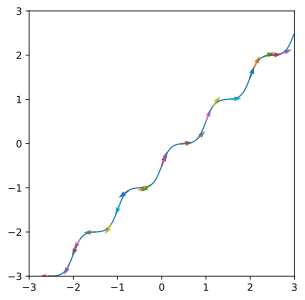

In [ ]:
f = softfloor_make(0.01)
t = 0.1*torch.randn(24, requires_grad=True) + 0.25*(torch.arange(24) - 12)
t.retain_grad()

loss = (f(t)[12:] - f(t)[:12]).sum()
loss.backward()

fig, ax = plt.subplots()
ax.set_aspect("equal")
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)

xs = torch.arange(-3, 3, 0.01)
ax.plot(xs, f(xs), linewidth=1.2, label=factor);

txs, tys = t.detach(), f(t.detach())

for tx, ty, tg in zip(txs, tys, t.grad.tolist()):
    delta = np.array([np.sign(tg), tg])
    delta = 0.1 * delta / np.linalg.norm(delta)

    lines2d = ax.plot([tx,tx+delta[0]], [ty, ty+delta[1]])[0]

    ax.arrow(tx, ty, *delta,
             head_width=0.11,
             fc=lines2d.get_color(),
             ec="none")

t, t.grad

Wavy identity function.

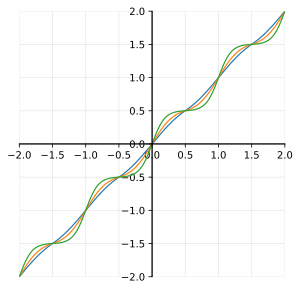

In [ ]:
fig, ax = plt.subplots()
ax.set_aspect("equal")
ax.grid(True, alpha=0.3)
for spine in ax.spines.values():
    spine.set_position("zero")

factors = [0.5, 1e-1, 1e-2]

xs = torch.arange(-3, 3, 0.01)
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)

for factor in factors:
    f = wavy_identity_make(factor)
    ax.plot(xs, f(xs), linewidth=1.2)